In [27]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes import NavierStokesPDEs

In [28]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

xmin, xmax = 0.0, 12.0
ymin, ymax = 0.0, 10.0

rho  = 1.0
mu   = 0.02
umax = 1.0

Set the default float type to float64


In [29]:
airfoil = Naca4DigitAirfoil(c=0.2, M=2, P=4, T=12, a=10, offset_x=5., offset_y=5.)

In [42]:
# Geometry defintion
farfield = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([4.9, 4.9], [5.1, 5.1])
mid_rec  = dde.geometry.Rectangle([2.5, 4.], [5., 6.])
outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)
mid_dom  = dde.geometry.CSGDifference(mid_rec, airfoil_geom)

In [45]:
Nf1 = 10000
Nf2 = 20000
Nf3 = 60000
Nb = 2000
Ns = 250

inner_points = inner_dom.random_points(Nf1)
mid_points = mid_dom.random_points(Nf2)
outer_points = outer_dom.random_points(Nf3)

farfield_points = farfield.random_boundary_points(Nb)
airfoil_points  = airfoil.get_boundary_points(Ns)

points = np.append(inner_points, mid_points, axis = 0)
points = np.append(points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

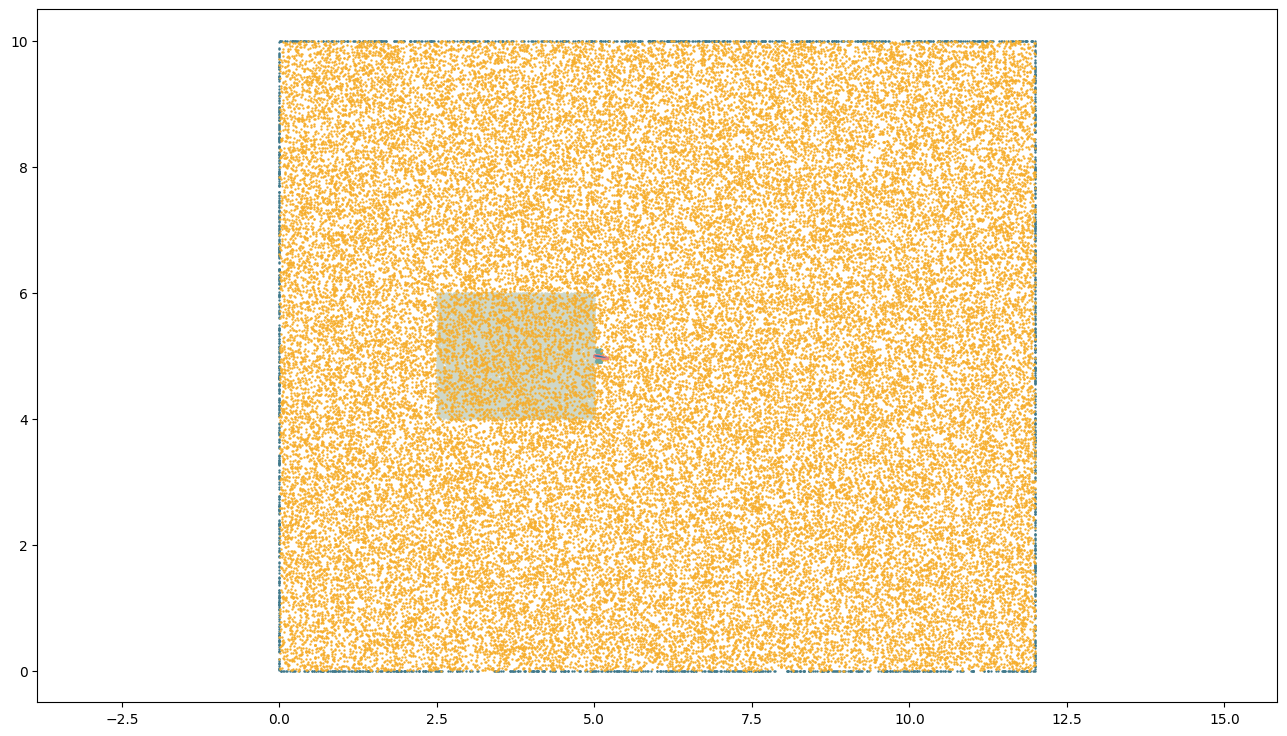

In [49]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.5, c='#40798C')  # Ocean blue for farfield points
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.5, c = '#70A9A1')  # Soft seafoam for inner points
plt.scatter(mid_points[:, 0], mid_points[:, 1], s = 0.5, c = '#CFD7C7')  # Sage green for mid points
plt.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.5, c = '#F6AE2D')  # Sunflower yellow for outer points
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])

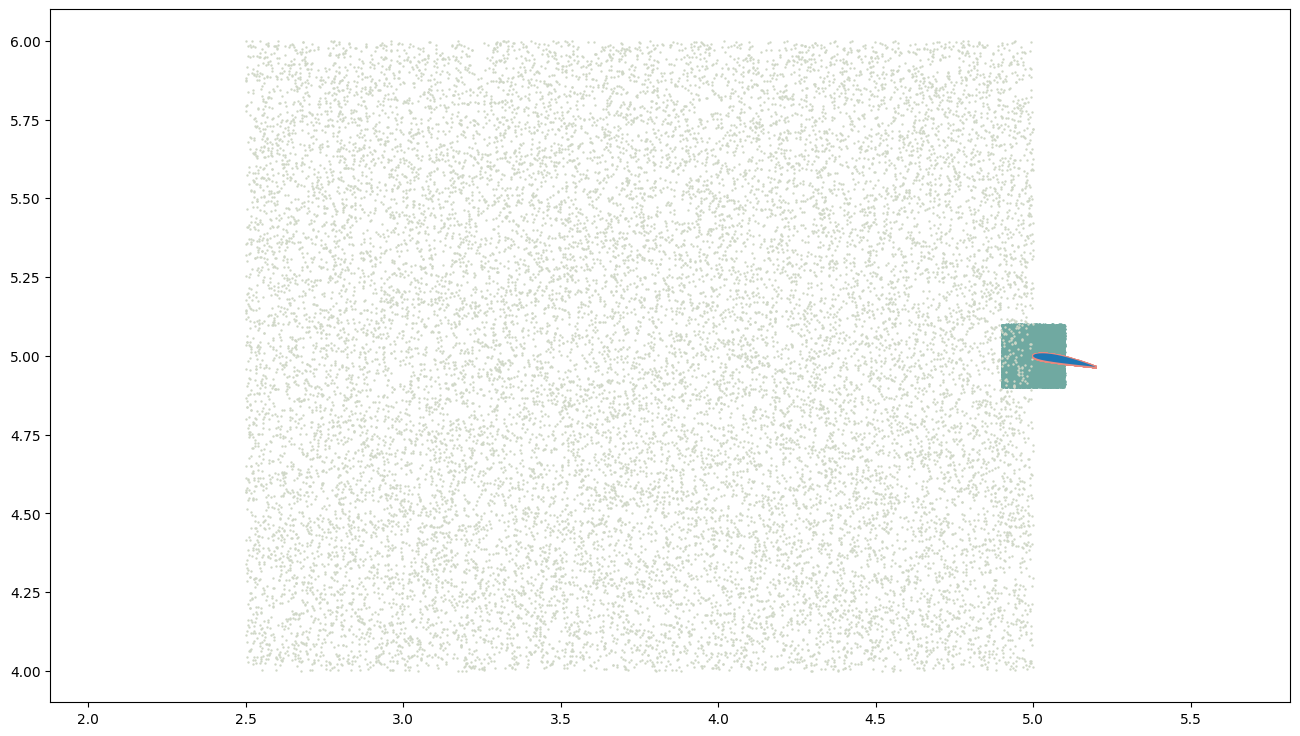

In [50]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.5, c = '#70A9A1')  # Soft seafoam for inner points
plt.scatter(mid_points[:, 0], mid_points[:, 1], s = 0.5, c = '#CFD7C7')  # Sage green for mid points
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])

In [ ]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                                      u_farfield=umax, v_farfield=0.0, p_farfield=0.0,
                                      airfoil_geom=airfoil_geom, geom=geom)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs()

In [ ]:
# Problem setup
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = 0, num_boundary = 0, num_test = 5000, anchors = points)

dde.config.set_default_float('float64')

In [ ]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [ ]:
# Neural network definition
layer_size  = [2] + [40] * 8 + [5]
activation  = 'tanh' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [ ]:
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs

try:
  losshistory, train_state = model.train(epochs = 50000, display_every = 100, model_save_path = './')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

In [ ]:
# model.compile(optimizer = 'L-BFGS-B', loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
# model.train_step.optimizer_kwargs = {'options': {'maxcor': 50, 
#                                                    'ftol': 1.0 * np.finfo(float).eps, 
#                                                    'maxfun':  50000, 
#                                                    'maxiter': 50000, 
#                                                    'maxls': 50}}
#
# losshistory, train_state = model.train(display_every = 1, model_save_path = './')
# dde.saveplot(losshistory, train_state, issave = True, isplot = True)

In [ ]:
# model.restore('./-10000.ckpt.index')

In [ ]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(xmin, xmax + dy, dx)
y = np.arange(ymin, ymax + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

In [ ]:
# # Model predictions generation
# u = model.predict(X, operator = navier_stokes_pdes.getU)
# v = model.predict(X, operator = navier_stokes_pdes.getV)
# p = model.predict(X, operator = navier_stokes_pdes.getP)

# for i in range(len(X)):
#    if airfoil_geom.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0

# u = u.reshape(len(y), len(x))
# v = v.reshape(len(y), len(x))
# p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
#ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(p.min(), 0.5, 0.001)
cnt1 = ax1.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('NACA0012NS0.png')

# fig2, ax2 = plt.subplots(figsize = (16, 9))
# ax2.streamplot(x, y, u, v, density = 1.5)
# clev = np.arange(0, u.max(), 0.001)
# cnt2 = ax2.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
# plt.axis('equal')
# plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
# fig2.colorbar(cnt2)
# plt.savefig('NACA0012NS1.png')

# fig3, ax3 = plt.subplots(figsize = (16, 9))
# ax3.streamplot(x, y, u, v, density = 1.5)
# clev = np.arange(-0.235, v.max(), 0.001)
# cnt3 = ax3.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
# plt.axis('equal')
# plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
# fig3.colorbar(cnt3)
# plt.savefig('NACA0012NS2.png')